# **La Liga 2023/24 Match Analysis**

## **Overview**
This notebook focuses on analyzing match data from the La Liga 2023/24 season to uncover insights into team performance, match outcomes, and season trends. By processing and enriching the dataset, we aim to provide valuable insights for fans, analysts, and stakeholders in European football.

---

## **Data Source**
The dataset includes detailed information about all matches played during the La Liga 2023/24 season. Key fields include:
- **Matchday**: The round of the league.
- **Match ID**: A unique identifier for each match.
- **Teams**: Home and Away teams.
- **Scores**: Final scorelines for each match.
- **UTC Time**: The date and time of the match in Coordinated Universal Time.

---

## **Key Objectives**
1. **Data Cleaning & Transformation**:
   - Process raw data to extract meaningful insights.
   - Split aggregate scores into home and away goals.
   - Add relevant columns such as total goals, goal differences, and match outcomes.

2. **Feature Engineering**:
   - Calculate cumulative goals and points for each team.
   - Categorize matches as "Top Clashes", "Relegation Battles", or "Regular Matches".
   - Extract temporal features (day of the week, month).

3. **Statistical Analysis**:
   - Analyze match outcomes (Home Wins, Away Wins, Draws).
   - Identify high-scoring matches and trends by matchday.

4. **Visualization**:
   - Plot distributions of match outcomes and goals.
   - Highlight key matches based on their importance.

---

## **Key Features Added**
- **Home and Away Scores**: Goals scored by each team in a match.
- **Total Goals**: Sum of goals scored in a match.
- **Goal Difference**: Difference between home and away goals.
- **Match Outcome**: Categorized as Home Win, Away Win, or Draw.
- **Cumulative Goals**: Running total of goals scored by teams throughout the season.
- **Matchday Average**: Average number of goals scored per matchday.
- **Above Matchday Average**: Indicator of matches exceeding the matchday average.
- **Match Importance**: Categorization of matches based on team quality and stakes.
- **Temporal Features**: Day of the week and month of the match.

---

## **Getting Started**
This notebook begins with importing the dataset, cleaning the data, and engineering new features. It then proceeds to explore match outcomes and team performance through statistical summaries and visualizations.


In [1]:
import datetime as dt  # For working with dates and times
from math import radians, sin, cos, sqrt, atan2
import os  # For file and directory handling
import pandas as pd  # For data manipulation
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For advanced visualization
import folium # geospatial mapping
from sklearn.preprocessing import StandardScaler  # For scaling data
from sklearn.decomposition import PCA  # For Principal Component Analysis
from sklearn.cluster import KMeans  # For clustering
from statsmodels.tsa.arima.model import ARIMA  # For ARIMA forecasting
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # For time series smoothing
from pmdarima import auto_arima  # For auto ARIMA model selection (optional)





In [2]:
# File paths for the datasets
matches_file_path = "FIFA_datasets/laliga2023_34/Laliga_matches_23_24.csv"
stadiums_file_path = "la_liga_stadiums.csv"

In [3]:
# Function to calculate haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [4]:
# Read and process the matches dataset
matches_df = (
    pd.read_csv(matches_file_path)
    .drop(columns=['Finished', 'Started', 'Cancelled', 'Awarded', 'Match Status', 'Unnamed: 12', 'Round Name'], errors='ignore')  # Drop unnecessary columns
    .assign(
        # Split the Score column into Home Score and Away Score
        Home_Score=lambda df: df['Score'].str.split('_', expand=True)[0].astype(int),
        Away_Score=lambda df: df['Score'].str.split('_', expand=True)[1].astype(int),
        # Add Total Goals, Home Goal Difference, and Away Goal Difference
        Total_Goals=lambda df: df['Home_Score'] + df['Away_Score'],
        Home_Goal_Difference=lambda df: df['Home_Score'] - df['Away_Score'],
        Away_Goal_Difference=lambda df: df['Away_Score'] - df['Home_Score'],
        # Determine Match Outcome
        Match_Outcome=lambda df: df.apply(
            lambda row: 'Home Win' if row['Home_Goal_Difference'] > 0 else (
                'Away Win' if row['Away_Goal_Difference'] > 0 else 'Draw'
            ), axis=1
        )
    )
    .drop(columns=['Score'])  # Drop the Score column after processing
    .rename(columns={'Round': 'Matchday'})  # Rename Round to Matchday
)

# Convert the 'UTC Time' column to a datetime object and set as index
matches_df['UTC Time'] = pd.to_datetime(matches_df['UTC Time'])
matches_df.set_index('UTC Time', inplace=True)

# Ensure the index retains the name 'UTC Time'
matches_df.index.name = 'UTC Time'

# Read the enhanced stadiums dataset
stadiums_df = pd.read_csv(stadiums_file_path)

# Merge stadium information for home teams
matches_df = matches_df.merge(
    stadiums_df, how='left', left_on='Home Team', right_on='Team'
).rename(columns={
    'Stadium Name': 'Home Stadium',
    'City': 'Home City',
    'Capacity': 'Home Stadium Capacity',
    'Latitude': 'Home Stadium Latitude',
    'Longitude': 'Home Stadium Longitude'
}).drop(columns=['Team'])  # Drop the duplicate Team column

# Merge stadium information for away teams
matches_df = matches_df.merge(
    stadiums_df, how='left', left_on='Away Team', right_on='Team'
).rename(columns={
    'Stadium Name': 'Away Stadium',
    'City': 'Away City',
    'Capacity': 'Away Stadium Capacity',
    'Latitude': 'Away Stadium Latitude',
    'Longitude': 'Away Stadium Longitude'
}).drop(columns=['Team'])  # Drop the duplicate Team column

# Calculate distance traveled for the away team
matches_df['Away Distance Traveled (km)'] = matches_df.apply(
    lambda row: haversine(
        row['Home Stadium Latitude'], row['Home Stadium Longitude'],
        row['Away Stadium Latitude'], row['Away Stadium Longitude']
    ) if not pd.isnull(row['Away Stadium Latitude']) and not pd.isnull(row['Home Stadium Latitude']) else None,
    axis=1
)

# Fill missing distances with 0 (if any)
matches_df['Away Distance Traveled (km)'] = matches_df['Away Distance Traveled (km)'].fillna(0)

In [5]:
matches_df.head()

,Matchday,Match ID,Home Team,Away Team,Home_Score,Away_Score,Total_Goals,Home_Goal_Difference,Away_Goal_Difference,Match_Outcome,...,Home City,Home Stadium Latitude,Home Stadium Longitude,Home Stadium Capacity,Away Stadium,Away City,Away Stadium Latitude,Away Stadium Longitude,Away Stadium Capacity,Away Distance Traveled (km)
0,1,4205343,Almeria,Rayo Vallecano,0,2,2,-2,2,Away Win,...,Almeria,36.8496,-2.4381,15000,Campo de Futbol de Vallecas,Madrid,40.3918,-3.6588,14708,407.888662
1,1,4205347,Sevilla,Valencia,1,2,3,-1,1,Away Win,...,Seville,37.3841,-5.9703,43883,Mestalla,Valencia,39.4746,-0.3585,49000,541.144868
2,1,4205351,Real Sociedad,Girona,1,1,2,0,0,Draw,...,San Sebastian,43.3018,-1.9731,39500,Estadi Montilivi,Girona,41.9630,2.8374,13500,420.672549
3,1,4205348,Las Palmas,Mallorca,1,1,2,0,0,Draw,...,Las Palmas,28.1248,-15.4300,32500,Visit Mallorca Estadi,Palma,39.5893,2.6502,23142,2093.619297
4,1,4205344,Athletic Club,Real Madrid,0,2,2,-2,2,Away Win,...,Bilbao,43.2641,-2.9494,53289,Santiago Bernabeu,Madrid,40.4531,-3.6884,81044,318.500299


In [7]:
matches_df.columns

Index(['Matchday', 'Match ID', 'Home Team', 'Away Team', 'Home_Score',
       'Away_Score', 'Total_Goals', 'Home_Goal_Difference',
       'Away_Goal_Difference', 'Match_Outcome', 'Home Stadium', 'Home City',
       'Home Stadium Latitude', 'Home Stadium Longitude',
       'Home Stadium Capacity', 'Away Stadium', 'Away City',
       'Away Stadium Latitude', 'Away Stadium Longitude',
       'Away Stadium Capacity', 'Away Distance Traveled (km)'],
      dtype='object')

Top 10 Home Teams with the Highest Scoring Matches:
Home Team
Girona             73
Villarreal         68
Atletico Madrid    64
Barcelona          64
Athletic Club      60
Almeria            58
Real Madrid        57
Granada            56
Sevilla            54
Real Betis         46
Name: Total_Goals, dtype: int64


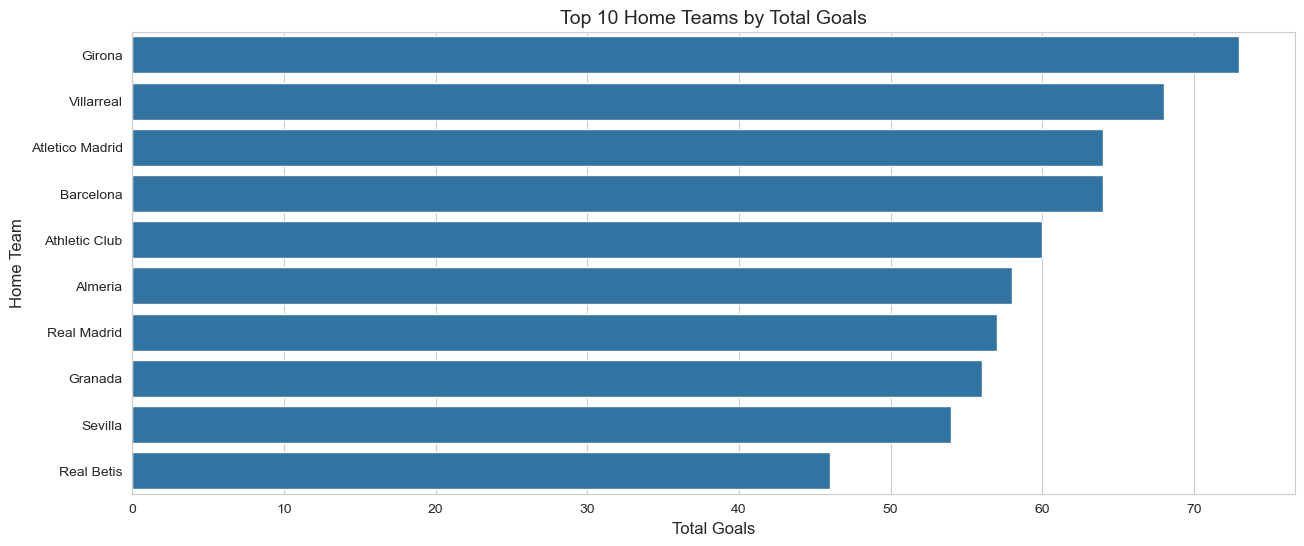

Average Distance and Away Wins:
                  Avg_Distance  Away_Wins
Away Team                                
Almeria             552.610668          2
Athletic Club       534.345607          7
Atletico Madrid     408.604182          8
Barcelona           601.310715         11
Cadiz               627.332913          1
Celta Vigo          707.896014          4
Deportivo Alaves    502.266273          3
Getafe              410.075352          2
Girona              664.884893         10
Granada             525.329623          0
Las Palmas         1795.458277          4
Mallorca            636.081209          2
Osasuna             507.992465          6
Rayo Vallecano      408.802036          4
Real Betis          559.778008          5
Real Madrid         410.012253         13
Real Sociedad       538.799816          8
Sevilla             557.959377          4
Valencia            473.432184          5
Villarreal          475.269005          7


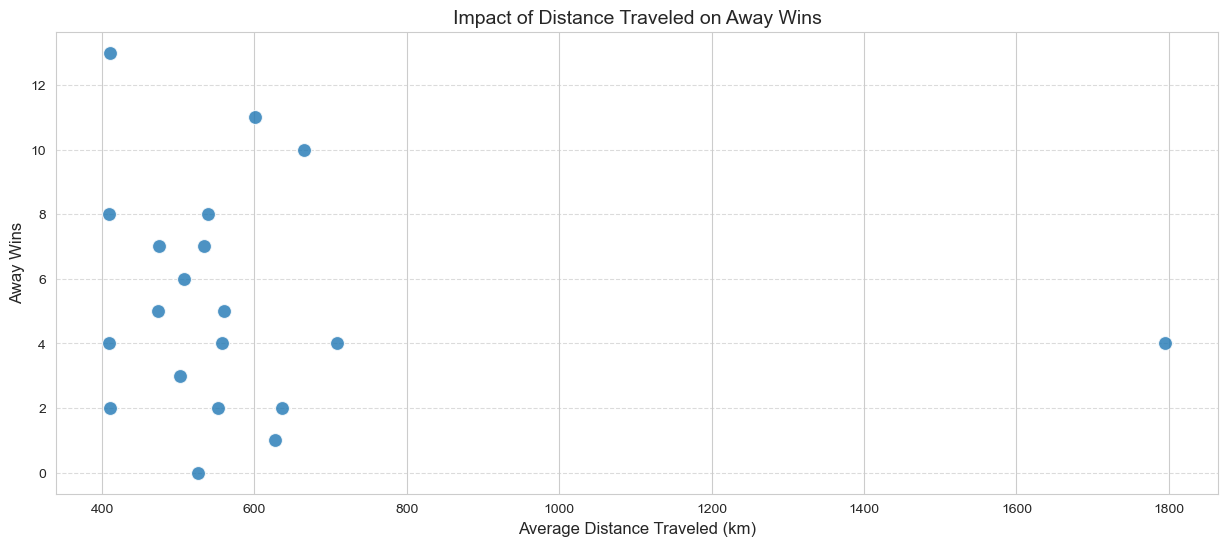

Stadiums with Highest Average Goals:
Home Stadium
Estadi Montilivi                       3.842105
Estadio de la Ceramica                 3.578947
Camp Nou                               3.368421
Wanda Metropolitano                    3.368421
San Mames                              3.157895
Estadio de los Juegos Mediterraneos    3.052632
Santiago Bernabeu                      3.000000
Estadio Nuevo Los Carmenes             2.947368
Ramon Sanchez Pizjuan                  2.842105
Estadio Benito Villamarin              2.421053
Name: Total_Goals, dtype: float64


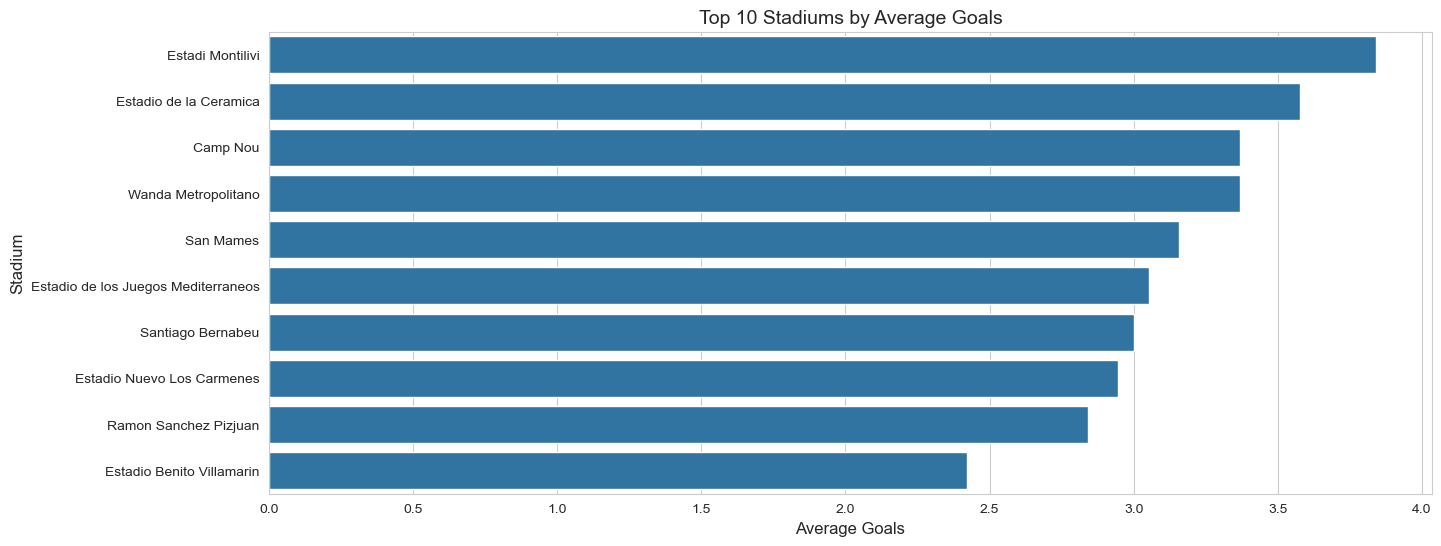

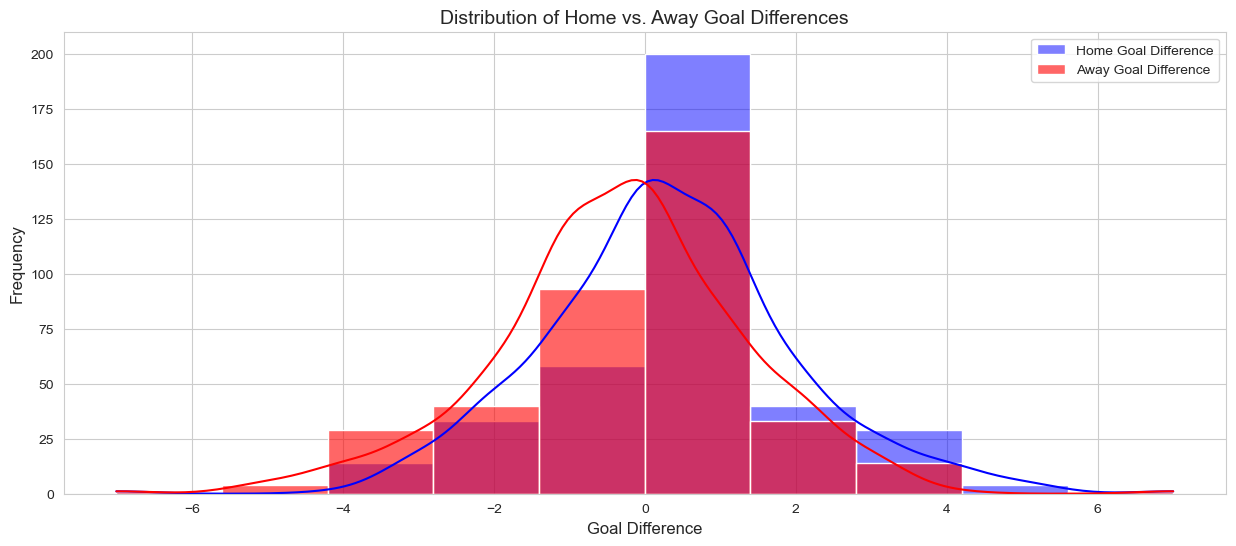

Most Difficult Stadiums for Away Teams:
                           Home_Wins
Home Stadium                        
Wanda Metropolitano               16
Santiago Bernabeu                 16
Camp Nou                          15
Estadi Montilivi                  15
San Mames                         12
Estadio Benito Villamarin          9
Mendizorrotza                      9
Coliseum Alfonso Perez             8
Reale Arena                        8
Mestalla                           8


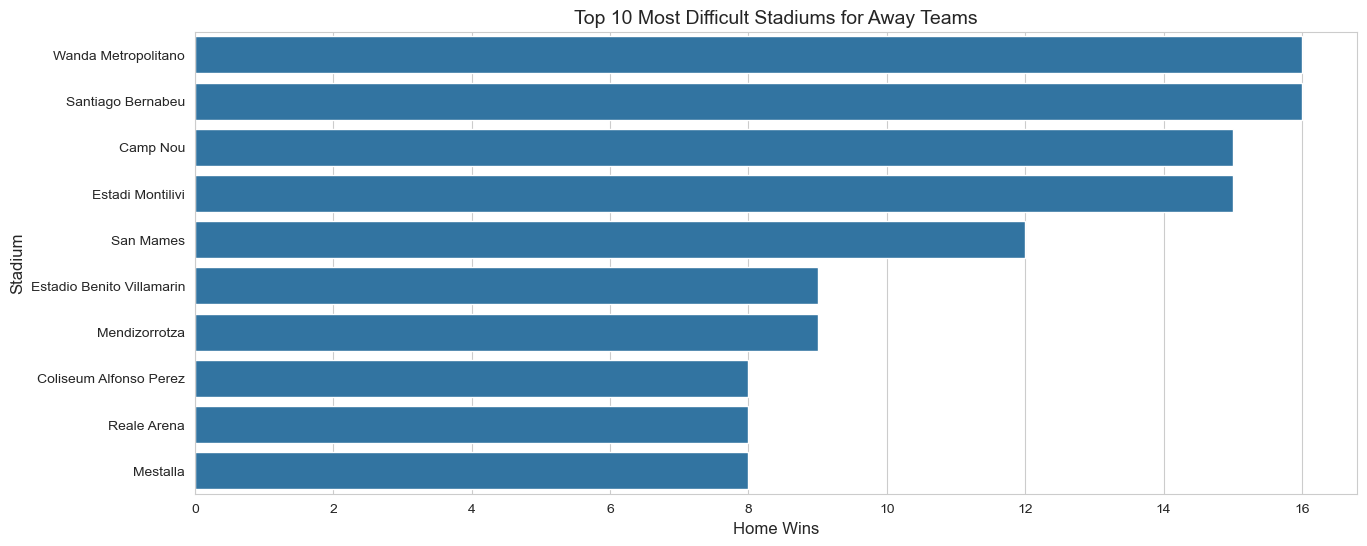

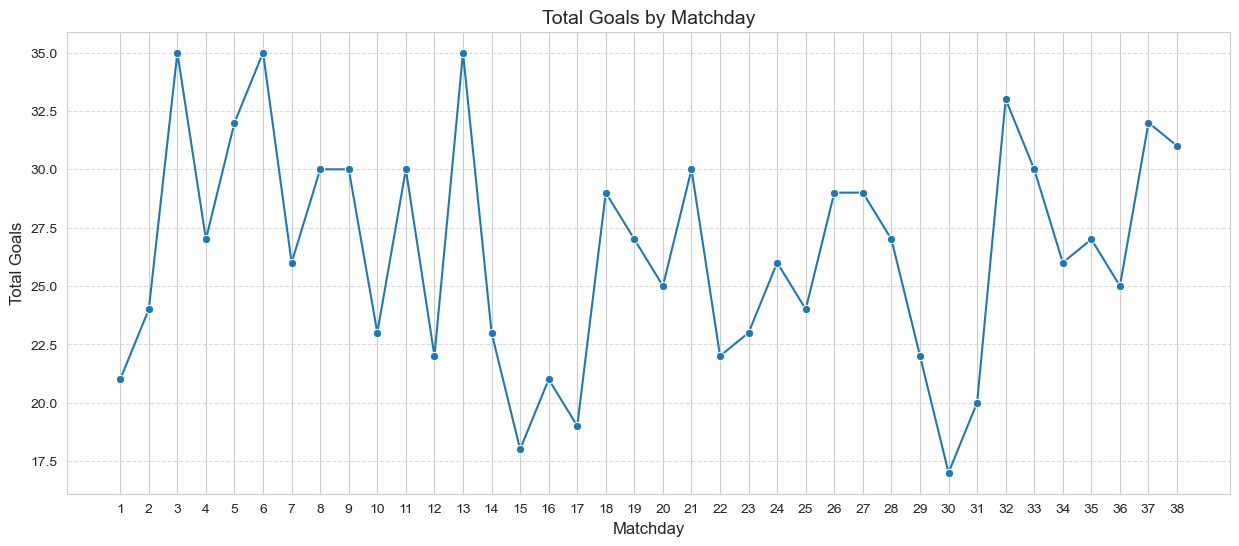

In [19]:
# 1. Top 10 Home Teams with the Highest Scoring Matches
top_home_teams = (
    matches_df.groupby('Home Team')['Total_Goals']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print("Top 10 Home Teams with the Highest Scoring Matches:")
print(top_home_teams)

sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))
sns.barplot(y=top_home_teams.index, x=top_home_teams.values, orient='h')
plt.title("Top 10 Home Teams by Total Goals", fontsize=14)
plt.xlabel("Total Goals", fontsize=12)
plt.ylabel("Home Team", fontsize=12)
plt.show()

# 2. Away Distance Impact on Performance
distance_performance = matches_df.groupby('Away Team').agg(
    Avg_Distance=('Away Distance Traveled (km)', 'mean'),
    Away_Wins=('Match_Outcome', lambda x: (x == 'Away Win').sum())
)
print("Average Distance and Away Wins:")
print(distance_performance)

# Set a universal style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))
sns.scatterplot(data=distance_performance, x='Avg_Distance', y='Away_Wins', s=100, alpha=0.8)
plt.title("Impact of Distance Traveled on Away Wins", fontsize=14)
plt.xlabel("Average Distance Traveled (km)", fontsize=12)
plt.ylabel("Away Wins", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Stadiums with Highest Average Goals
high_avg_goals_stadiums = (
    matches_df.groupby('Home Stadium')['Total_Goals']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
print("Stadiums with Highest Average Goals:")
print(high_avg_goals_stadiums)

# Set a universal style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))
sns.barplot(y=high_avg_goals_stadiums.index, x=high_avg_goals_stadiums.values, orient='h')
plt.title("Top 10 Stadiums by Average Goals", fontsize=14)
plt.xlabel("Average Goals", fontsize=12)
plt.ylabel("Stadium", fontsize=12)
plt.show()

# 4. Distribution of Home and Away Goal Differences

# Set a universal style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))
sns.histplot(matches_df['Home_Goal_Difference'], bins=10, kde=True, color='blue', label='Home Goal Difference')
sns.histplot(matches_df['Away_Goal_Difference'], bins=10, kde=True, color='red', label='Away Goal Difference', alpha=0.6)
plt.title("Distribution of Home vs. Away Goal Differences", fontsize=14)
plt.xlabel("Goal Difference", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=10)
plt.show()

# 5. Most Difficult Stadiums for Away Teams
difficult_stadiums = (
    matches_df.groupby('Home Stadium')
    .agg(Home_Wins=('Match_Outcome', lambda x: (x == 'Home Win').sum()))
    .sort_values(by='Home_Wins', ascending=False)
    .head(10)
)
print("Most Difficult Stadiums for Away Teams:")
print(difficult_stadiums)

# Set a universal style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))
sns.barplot(y=difficult_stadiums.index, x=difficult_stadiums['Home_Wins'], orient='h')
plt.title("Top 10 Most Difficult Stadiums for Away Teams", fontsize=14)
plt.xlabel("Home Wins", fontsize=12)
plt.ylabel("Stadium", fontsize=12)
plt.show()

# 6. Total Goals per Matchday

total_goals_per_matchday = matches_df.groupby('Matchday')['Total_Goals'].sum()

# Line Plot for Total Goals by Matchday

# Set a universal style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(x=total_goals_per_matchday.index, y=total_goals_per_matchday.values, marker='o')
plt.title("Total Goals by Matchday", fontsize=14)
plt.xlabel("Matchday", fontsize=12)
plt.ylabel("Total Goals", fontsize=12)
plt.xticks(total_goals_per_matchday.index)  # Ensure matchday ticks are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



---

### Match Outcome Percentages

Based on the analysis of the La Liga 2023/24 season matches, the outcomes are distributed as follows:

- **Home Wins**: 43.95% of matches were won by the home team.
- **Away Wins**: 27.89% of matches were won by the away team.
- **Draws**: 28.16% of matches ended in a draw.

This highlights the advantage of playing at home, as home teams secured nearly 44% of the victories.


---

# Advanced Analysis and Insights for La Liga 2023/24

---

## 1. **Team Performance Analysis**
### **Home vs Away Performance:**
- Calculate and compare average goals scored and conceded at home vs. away.
- Evaluate win percentages for home and away matches.

### **Dominance Metrics:**
- Identify the most dominant teams based on goal difference, points, or win streaks.

### **Top Performing Teams:**
- Rank teams by their total points, goals scored, and goals conceded.

---



In [ ]:
matches_df.columns

# Which Team Scored the Most Goals in a Single Match?

In [ ]:
# Find the match where the Home Team scored the most goals
home_most_goals_match = matches_df.loc[matches_df['Home_Score'].idxmax()]

# Find the match where the Away Team scored the most goals
away_most_goals_match = matches_df.loc[matches_df['Away_Score'].idxmax()]

# Create a function to format the match score
def format_match_score(row):
    return f"{row['Home_Score']} - {row['Away_Score']}"

# Print the results
print("Match with Most Goals by a Home Team:")
print(home_most_goals_match[['Home Team', 'Away Team', 'Match_Outcome', 'Total_Goals']])
print(f"Match Score: {format_match_score(home_most_goals_match)}\n")

print("Match with Most Goals by an Away Team:")
print(away_most_goals_match[['Home Team', 'Away Team', 'Match_Outcome', 'Total_Goals']])
print(f"Match Score: {format_match_score(away_most_goals_match)}")


# What is the Average Travel Distance for Away Teams?

In [ ]:
average_travel_distance = matches_df['Away Distance Traveled (km)'].mean()
print(f"Average Travel Distance for Away Teams: {average_travel_distance:.2f} km")


# Which Team has the Highest Average Home Goal Difference?

In [ ]:
home_goal_diff_avg = matches_df.groupby('Home Team')['Home_Goal_Difference'].mean().sort_values(ascending=False)
print("Teams with Highest Average Home Goal Difference:")
print(home_goal_diff_avg.head(5))


# How Does Travel Distance Affect Away Team Performance?



In [ ]:
sns.scatterplot(x='Away Distance Traveled (km)', y='Away_Goal_Difference', data=matches_df)
plt.title("Effect of Travel Distance on Away Team Performance")
plt.xlabel("Away Distance Traveled (km)")
plt.ylabel("Away Goal Difference")
plt.show()

# What is the Distribution of Home, Away and Total Goals Across Matches?

In [ ]:
# Distribution of Away Goals in Matches
sns.histplot(matches_df['Away_Score'], bins=8, kde=True)
plt.title("Distribution of Away Goals in Matches", fontsize=14)
plt.xlabel("Away Goals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Distribution of Home Goals in Matches
sns.histplot(matches_df['Home_Score'], bins=8, kde=True)
plt.title("Distribution of Home Goals in Matches", fontsize=14)
plt.xlabel("Home Goals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
sns.histplot(matches_df['Total_Goals'], bins=8, kde=True)
plt.title("Distribution of Total Goals in Matches")
plt.xlabel("Total Goals")
plt.ylabel("Frequency")
plt.show()


# Which City Hosts the Most Matches?

In [ ]:
city_match_counts = matches_df['Home City'].value_counts()
print("Top 5 Cities Hosting the Most Matches:")
print(city_match_counts.head(5))


# How Many Matches Ended in a Draw?

In [ ]:
draw_count = matches_df[matches_df['Match_Outcome'] == 'Draw'].shape[0]
print(f"Number of Matches Ending in a Draw: {draw_count}")


# What are the Top 5 High-Scoring Matches?

In [ ]:
high_scoring_matches = matches_df.sort_values(by='Total_Goals', ascending=False).head(20)
print("Top 5 High-Scoring Matches:")
print(high_scoring_matches[['Home Team', 'Away Team', 'Match_Outcome', 'Total_Goals', 'Matchday']])


In [ ]:
matches_df.head()

In [ ]:
matches_df.columns

# Line Plot: Total Goals as a Time Series

In [ ]:
# Convert index to datetime for timeseries plotting if not already done
matches_df.reset_index(inplace=True)

# Line plot for total goals over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='UTC Time', y='Total_Goals', data=matches_df, marker='o')
plt.title("Total Goals Over Time", fontsize=14)
plt.xlabel("Match Date", fontsize=12)
plt.ylabel("Total Goals", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Line Plot: Home Goals and Away Goals Grouped by Matchday

In [ ]:
# Group data by Matchday and calculate average goals
grouped_goals = matches_df.groupby('Matchday').agg(
    Average_Home_Goals=('Home_Score', 'mean'),
    Average_Away_Goals=('Away_Score', 'mean')
).reset_index()

# Melt the data for easier plotting with seaborn
melted_goals = grouped_goals.melt(id_vars='Matchday', 
                                  value_vars=['Average_Home_Goals', 'Average_Away_Goals'],
                                  var_name='Goal Type', value_name='Average Goals')

# Line plot for home and away goals grouped by matchday
plt.figure(figsize=(12, 6))
sns.lineplot(x='Matchday', y='Average Goals', hue='Goal Type', data=melted_goals, marker='o')
plt.title("Home and Away Goals Across Matchdays", fontsize=14)
plt.xlabel("Matchday", fontsize=12)
plt.ylabel("Average Goals", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Goal Type", loc='upper right')
plt.show()


In [ ]:
# Home vs Away Performance
home_performance = matches_df.groupby('Home Team').agg(
    Home_Goals_Scored=('Home_Score', 'sum'),
    Home_Goals_Conceded=('Away_Score', 'sum'),
    Home_Wins=('Match_Outcome', lambda x: (x == 'Home Win').sum()),
    Home_Draws=('Match_Outcome', lambda x: (x == 'Draw').sum()),
    Home_Losses=('Match_Outcome', lambda x: (x == 'Away Win').sum()),
    Home_Matches=('Match_Outcome', 'count')
)
home_performance['Home_Win_Percentage'] = (home_performance['Home_Wins'] / home_performance['Home_Matches']) * 100

away_performance = matches_df.groupby('Away Team').agg(
    Away_Goals_Scored=('Away_Score', 'sum'),
    Away_Goals_Conceded=('Home_Score', 'sum'),
    Away_Wins=('Match_Outcome', lambda x: (x == 'Away Win').sum()),
    Away_Draws=('Match_Outcome', lambda x: (x == 'Draw').sum()),
    Away_Losses=('Match_Outcome', lambda x: (x == 'Home Win').sum()),
    Away_Matches=('Match_Outcome', 'count')
)
away_performance['Away_Win_Percentage'] = (away_performance['Away_Wins'] / away_performance['Away_Matches']) * 100

# Merge Home and Away Performance
team_performance = home_performance.merge(
    away_performance,
    left_index=True,
    right_index=True,
    suffixes=('_Home', '_Away')
)

# Dominance Metrics
team_performance['Total_Goals_Scored'] = team_performance['Home_Goals_Scored'] + team_performance['Away_Goals_Scored']
team_performance['Total_Goals_Conceded'] = team_performance['Home_Goals_Conceded'] + team_performance['Away_Goals_Conceded']
team_performance['Goal_Difference'] = team_performance['Total_Goals_Scored'] - team_performance['Total_Goals_Conceded']
team_performance['Total_Wins'] = team_performance['Home_Wins'] + team_performance['Away_Wins']
team_performance['Total_Draws'] = team_performance['Home_Draws'] + team_performance['Away_Draws']
team_performance['Total_Losses'] = team_performance['Home_Losses'] + team_performance['Away_Losses']
team_performance['Total_Matches'] = team_performance['Home_Matches'] + team_performance['Away_Matches']
team_performance['Total_Points'] = (team_performance['Total_Wins'] * 3) + team_performance['Total_Draws']

# Top Performing Teams
top_teams = team_performance.sort_values(by='Total_Points', ascending=False)

# Display insights
print("\n--- Team Performance Analysis ---")
print("\nHome vs Away Performance:")
print(team_performance[['Home_Win_Percentage', 'Away_Win_Percentage']].sort_values(by='Home_Win_Percentage', ascending=False).head(10))

print("\nTop Performing Teams by Total Points:")
print(top_teams[['Total_Points', 'Total_Wins', 'Goal_Difference']].head(10))

plt.figure(figsize=(12, 6))
top_teams['Total_Points'].head(10).plot(kind='bar', color='blue', alpha=0.7)
plt.title("Top 10 Teams by Total Points", fontsize=14)
plt.xlabel("Teams", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
matches_df

## 2. **Match Insights**
### **High-Scoring Matches:**
- Identify the matches with the highest total goals.
- Analyze if high-scoring matches are more common at specific stadiums or involving certain teams.

### **Distance Impact:**
- Investigate if greater travel distances for away teams correlate with poorer performance (e.g., fewer goals scored or lower win percentage).

### **Stadium Influence:**
- Compare the performance of teams at large vs. small-capacity stadiums.
- Determine if certain stadiums are harder to win at ("fortresses").

---




In [ ]:
# High-Scoring Matches
high_scoring_matches = matches_df.sort_values(by='Total_Goals', ascending=False).head(10)


# Analyze high-scoring matches by stadium
high_scoring_stadiums = matches_df.groupby('Home Stadium')['Total_Goals'].mean().sort_values(ascending=False)


# Visualization: High-Scoring Stadiums
plt.figure(figsize=(12, 6))
sns.barplot(
    x=high_scoring_stadiums.head(10).index,
    y=high_scoring_stadiums.head(10).values,
    palette="viridis"
)
plt.title("Top 10 Stadiums by Average Goals Scored", fontsize=14)
plt.xlabel("Stadiums", fontsize=12)
plt.ylabel("Average Total Goals", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate and align x-tick labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Visualization: Stadium Influence
plt.figure(figsize=(14, 7))
sns.scatterplot(
    x='Stadium_Capacity',
    y='Home_Win_Percentage',
    size='Total_Matches',
    sizes=(50, 300),
    hue='Home_Win_Percentage',
    palette="coolwarm",
    data=stadium_influence.reset_index()
)
plt.title("Stadium Influence: Home Win Percentage vs. Capacity", fontsize=16)
plt.xlabel("Stadium Capacity", fontsize=12)
plt.ylabel("Home Win Percentage (%)", fontsize=12)
plt.legend(title="Win %", loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



---

## 3. **Seasonal Trends**
### **Goal Trends Over Matchdays:**
- Analyze trends in total goals scored across matchdays.
- Determine if certain parts of the season (e.g., beginning, middle, or end) have more high-scoring matches.

### **Travel Trends:**
- Evaluate which teams traveled the most and the least during the season.
- Correlate travel distances with match outcomes and fatigue effects.

---

## 4. **Geographic Insights**
### **Regional Rivalries:**
- Highlight matches between geographically close teams ("derbies").
- Analyze their intensity based on goals, cards, or outcomes.

### **Travel Hotspots:**
- Identify teams or stadiums that require the most travel for away teams.

---

In [ ]:
# Analyze Total Goals Scored Across Matchdays
matchday_goals = matches_df.groupby('Matchday')['Total_Goals'].sum()

# Visualization: Goal Trends Over Matchdays
plt.figure(figsize=(14, 6))
sns.lineplot(data=matchday_goals, marker='o', color='blue')
plt.title("Total Goals Scored Over Matchdays", fontsize=16)
plt.xlabel("Matchday", fontsize=12)
plt.ylabel("Total Goals Scored", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Determine Travel Trends
travel_trends = matches_df.groupby('Away Team')['Away Distance Traveled (km)'].sum().sort_values(ascending=False)

# Teams that traveled the most and least during the season
most_travel = travel_trends.head(5)
least_travel = travel_trends.tail(5)

print("\n--- Teams with the Most Travel ---")
print(most_travel)

print("\n--- Teams with the Least Travel ---")
print(least_travel)

# Visualization: Travel Trends
plt.figure(figsize=(14, 6))
sns.barplot(
    x=most_travel.index,
    y=most_travel.values,
    palette="Blues_d"
)
plt.title("Top 5 Teams with the Most Travel", fontsize=16)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Total Distance Traveled (km)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(
    x=least_travel.index,
    y=least_travel.values,
    palette="Greens_d"
)
plt.title("Top 5 Teams with the Least Travel", fontsize=16)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Total Distance Traveled (km)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Correlation Between Travel Distance and Match Outcomes
travel_impact = matches_df.groupby('Away Team').agg(
    Total_Travel=('Away Distance Traveled (km)', 'sum'),
    Away_Wins=('Match_Outcome', lambda x: (x == 'Away Win').sum()),
    Away_Draws=('Match_Outcome', lambda x: (x == 'Draw').sum()),
    Away_Losses=('Match_Outcome', lambda x: ((x != 'Away Win') & (x != 'Draw')).sum())
)
travel_impact['Win_Percentage'] = (travel_impact['Away_Wins'] / 
                                   (travel_impact['Away_Wins'] + travel_impact['Away_Draws'] + travel_impact['Away_Losses'])) * 100

# Visualization: Travel Distance vs. Win Percentage
plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='Total_Travel',
    y='Win_Percentage',
    size='Total_Travel',
    sizes=(50, 300),
    hue='Win_Percentage',
    palette="coolwarm",
    data=travel_impact
)
plt.title("Travel Distance vs. Away Win Percentage", fontsize=16)
plt.xlabel("Total Travel Distance (km)", fontsize=12)
plt.ylabel("Away Win Percentage (%)", fontsize=12)
plt.legend(title="Win %", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 5. **Player and Team Behavior**

### **Defensive Solidity:**
- Highlight teams that rarely concede goals, especially at home.

---





In [ ]:
# Analyze Defensive Solidity
# Aggregating data for goals conceded by teams at home
defensive_solidity = matches_df.groupby('Home Team').agg(
    Total_Home_Goals_Conceded=('Away_Score', 'sum'),
    Total_Home_Matches=('Home Team', 'count'),
    Avg_Home_Goals_Conceded_Per_Match=('Away_Score', 'mean')
).sort_values(by='Avg_Home_Goals_Conceded_Per_Match')

# Add a rank to highlight the most defensively solid teams
defensive_solidity['Defensive Rank'] = defensive_solidity['Avg_Home_Goals_Conceded_Per_Match'].rank()

print("\n--- Defensive Solidity: Teams Rarely Conceding Goals at Home ---")
print(defensive_solidity.head(10))

# Visualization: Defensive Solidity (Top 10 Teams)
plt.figure(figsize=(14, 6))
sns.barplot(
    x=defensive_solidity.head(10).index,
    y=defensive_solidity['Avg_Home_Goals_Conceded_Per_Match'].head(10),
    hue=defensive_solidity.head(10).index,  # Assign the `x` variable to `hue`
    dodge=False,  # Ensure bars are not split
    palette="Blues_d",
    legend=False  # No legend required for this use case
)
plt.title("Top 10 Teams by Defensive Solidity at Home", fontsize=16)
plt.xlabel("Teams", fontsize=12)
plt.ylabel("Average Goals Conceded Per Home Match", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
# Stadium data
data = {
    "Team": [
        "Real Madrid", "Barcelona", "Atletico Madrid", "Sevilla", "Valencia", "Real Sociedad",
        "Athletic Club", "Villarreal", "Real Betis", "Mallorca", "Rayo Vallecano", "Osasuna",
        "Getafe", "Celta Vigo", "Almeria", "Granada", "Las Palmas", "Girona", "Cadiz", "Elche",
        "Deportivo Alaves"
    ],
    "Stadium Name": [
        "Santiago Bernabeu", "Camp Nou", "Wanda Metropolitano", "Ramon Sanchez Pizjuan",
        "Mestalla", "Reale Arena", "San Mames", "Estadio de la Ceramica", "Estadio Benito Villamarin",
        "Visit Mallorca Estadi", "Campo de Futbol de Vallecas", "Estadio El Sadar",
        "Coliseum Alfonso Perez", "Balaidos", "Estadio de los Juegos Mediterraneos",
        "Estadio Nuevo Los Carmenes", "Estadio Gran Canaria", "Estadi Montilivi",
        "Estadio Nuevo Mirandilla", "Estadio Manuel Martinez Valero", "Mendizorrotza"
    ],
    "City": [
        "Madrid", "Barcelona", "Madrid", "Seville", "Valencia", "San Sebastian", "Bilbao", 
        "Villarreal", "Seville", "Palma", "Madrid", "Pamplona", "Getafe", "Vigo", "Almeria", 
        "Granada", "Las Palmas", "Girona", "Cadiz", "Elche", "Vitoria-Gasteiz"
    ],
    "Latitude": [
        40.4531, 41.3809, 40.4362, 37.3841, 39.4746, 43.3018, 43.2641, 39.9445, 37.3565,
        39.5893, 40.3918, 42.7951, 40.3250, 42.2118, 36.8496, 37.1463, 28.1248, 41.9630,
        36.5083, 38.2668, 42.8498
    ],
    "Longitude": [
        -3.6884, 2.1228, -3.5994, -5.9703, -0.3585, -1.9731, -2.9494, -0.1032, -5.9812,
        2.6502, -3.6588, -1.6376, -3.7146, -8.7392, -2.4381, -3.6025, -15.4300, 2.8374,
        -6.2722, -0.6630, -2.6813
    ],
    "Capacity": [
        81044, 99354, 68456, 43883, 49000, 39500, 53289, 23500, 60721, 23142, 14708, 
        23516, 17393, 29000, 15000, 23156, 32500, 13500, 20000, 31088, 19840
    ]
}

# Convert to DataFrame
stadiums_df = pd.DataFrame(data)

# Create a folium map
spain_map = folium.Map(location=[40.4637, -3.7492], zoom_start=6, tiles="OpenStreetMap")

# Add stadium markers
for _, row in stadiums_df.iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=row["Capacity"] / 10000,  # Scale marker size by stadium capacity
        popup=f"<b>Team:</b> {row['Team']}<br><b>Stadium:</b> {row['Stadium Name']}<br><b>Capacity:</b> {row['Capacity']}<br><b>City:</b> {row['City']}",
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6
    ).add_to(spain_map)

# Save the map to an HTML file
spain_map.save("la_liga_stadiums_map.html")
print("Map saved as 'la_liga_stadiums_map.html'")


## 6. **Attendance and Revenue Potential**
*(If attendance data is available or estimations can be derived based on stadium capacity):*
- Analyze average attendance for home matches.
- Estimate potential revenue from ticket sales using average attendance and ticket prices.

---

## 7. **Clustering and Segmentation**
- Use clustering algorithms to group teams based on:
  - Scoring patterns (e.g., high-scoring vs. defensively solid teams).
  - Travel and performance patterns (e.g., teams that struggle in away matches).

---

## 8. **Predictive Modeling**
### **Match Outcome Prediction:**
- Use features like distance traveled, team form, and goals scored/conceded to predict match outcomes.

### **Relegation Risk:**
- Analyze which teams are at risk of relegation based on their points and remaining fixtures.

---



## 9. **Interactive Visualizations**
- Create visualizations to explore:
  - Heatmaps of travel distances between stadiums.
  - Scatter plots of goals scored vs. goals conceded.
  - Maps showing the locations of stadiums and travel routes.

---



## 10. **Rivalry and Competition Intensity**
- Identify intense rivalries based on:
  - Goal differences across matches.
  - Historical win-loss records between teams.

---